# Data Diri

Nama: Sahrial Ihsani Ishak

Asal: Bengkulu




# Code
Dataset : Denpasar Weather:
https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata?select=openweatherdata-denpasar-1990-2020v0.1.csv

Create your own kaggle api token

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrialihsaniishak","key":"1cd8c1d5abed5608434908e6b1d8d093"}'}

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d cornflake15/denpasarbalihistoricalweatherdata
!ls

  0% 0.00/7.32M [00:00<?, ?B/s]
100% 7.32M/7.32M [00:00<00:00, 66.7MB/s]
denpasarbalihistoricalweatherdata.zip  drive  kaggle.json  sample_data


In [5]:
import zipfile
local_zip = '/content/denpasarbalihistoricalweatherdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
#Import Library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
#Read CSV and display the data
dataset = pd.read_csv('/content/openweatherdata-denpasar-1990-2020v0.1.csv')
display(dataset)

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1/1/1990 0:00,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,1/1/1990 1:00,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,1/1/1990 2:00,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,1/1/1990 3:00,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,1/1/1990 4:00,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,1/7/2020 19:00,28800,Denpasar,-8.652497,115.219117,27.00,27.00,27.00,1007.0,94,4.10,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264920,1/7/2020 20:00,28800,Denpasar,-8.652497,115.219117,27.00,27.00,27.00,1007.0,94,5.70,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264921,1/7/2020 21:00,28800,Denpasar,-8.652497,115.219117,28.00,28.00,28.00,1007.0,83,6.70,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264922,1/7/2020 22:00,28800,Denpasar,-8.652497,115.219117,28.00,28.00,28.00,1007.0,83,6.20,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n


In [8]:
#Check data null
dataset.isnull().sum()

dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
temp_min                    0
temp_max                    0
pressure                    0
humidity                    0
wind_speed                  0
wind_deg                    0
rain_1h                248638
rain_3h                248768
rain_6h                228826
rain_12h               264912
rain_24h               258107
rain_today             264924
snow_1h                264924
snow_3h                264924
snow_6h                264924
snow_12h               264924
snow_24h               264924
snow_today             264924
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

In [9]:
#Drop attribute that not used
dataset = dataset.drop(dataset.columns[[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                        20, 21, 22, 23, 24, 25, 26, 27, 28]],axis=1)
display(dataset.head())

,dt_iso,temp
0,1/1/1990 0:00,25.82
1,1/1/1990 1:00,26.20
2,1/1/1990 2:00,26.45
3,1/1/1990 3:00,26.80
4,1/1/1990 4:00,27.04


In [10]:
#Check data is null
dataset.isnull().sum()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt_iso  264924 non-null  object 
 1   temp    264924 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.0+ MB


In [11]:
#Rename Attribute dt_iso into date
dataset = dataset.rename(columns={'dt_iso': 'date'})
display(dataset.head())

,date,temp
0,1/1/1990 0:00,25.82
1,1/1/1990 1:00,26.20
2,1/1/1990 2:00,26.45
3,1/1/1990 3:00,26.80
4,1/1/1990 4:00,27.04


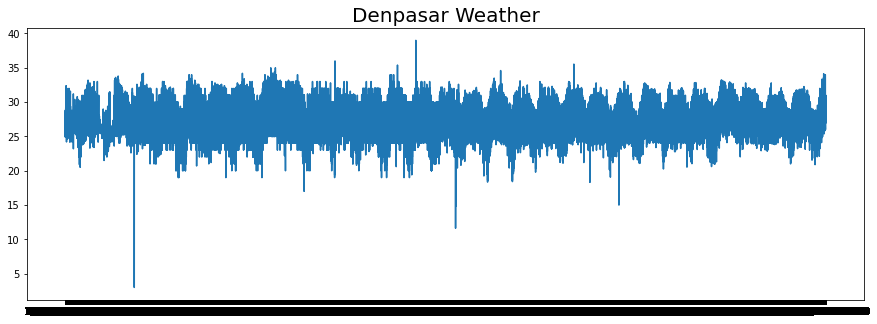

In [12]:
#Plot time series
date = dataset['date'].values
temperature  = dataset['temp'].values
plt.figure(figsize=(15,5))
plt.plot(date, temperature)
plt.title('Denpasar Weather',
          fontsize=20);


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(temperature, date, test_size = 0.2, random_state = 42)
print("X Train= ",len(X_train))
print("X Vaidation= ",len(X_validation))
print("Y train= ",len(y_train))
print("Y Validation= ",len(y_validation))

X Train=  211939
X Vaidation=  52985
Y train=  211939
Y Validation=  52985


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [15]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(X_train, window_size=64, batch_size=1024, shuffle_buffer=1000)
validation_set = windowed_dataset(X_validation, window_size=64, batch_size=1024, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"), 
  tf.keras.layers.Dense(1),
])

In [16]:
#Menghitung nilai mae
Mae = (dataset['temp'].max() - dataset['temp'].min()) * 0.1
print("Temp Max= ",dataset['temp'].max())
print("Temp Min= ",dataset['temp'].min())
print("MAE= ",Mae)

Temp Max=  39.0
Temp Min=  3.0
MAE=  3.6


In [17]:
#Callback 10% mae
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<3.6 and logs.get('val_mae')<3.6):
      print("MAE < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,metrics=["mae"])
trainmodel = model.fit(train_set,epochs=100,validation_data=validation_set,verbose=2,callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


207/207 - 305s - loss: 25.4961 - mae: 25.9961 - val_loss: 23.4023 - val_mae: 23.9023
Epoch 2/100
207/207 - 305s - loss: 11.0130 - mae: 11.4884 - val_loss: 1.1434 - val_mae: 1.5711
Epoch 3/100
207/207 - 308s - loss: 1.1350 - mae: 1.5625 - val_loss: 1.1434 - val_mae: 1.5712
MAE < 10% skala data


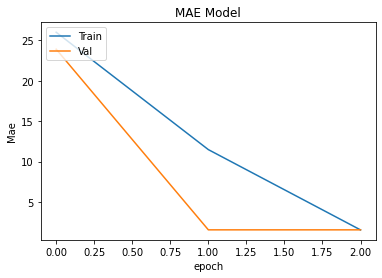

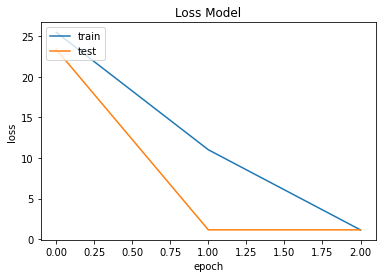

In [19]:
#Plot MAE and Loss
import matplotlib.pyplot as plt
# MAE
plt.plot(trainmodel.history['mae'])
plt.plot(trainmodel.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()  
#Loss
plt.plot(trainmodel.history['loss'])
plt.plot(trainmodel.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()